**Billy Cen**

**01 Jul 2022**

**Capstone**

# Objectives: 

- Identify key features of home equity loaners that are correlated with:
> - \# of serious delinquencies, late payments
> - Failures to repay credit payments 30-60 days post-due-date
> - Debt:income ratio **(monthly \\$ debt/monthly \\$ income)**
- Build a classification model to predict clients who are likely to default on their loan.  
- Share recommendations to the bank on the important features to consider while approving a loan.

# Prep

### Import

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,precision_score,recall_score,f1_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV


import scipy.stats as stats


import warnings
warnings.filterwarnings('ignore')

### Read in .csv

In [2]:
data = pd.read_csv("hmeq.csv")
hmeq = data.copy()

### Load metadata

In [3]:
hmeq.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [4]:
hmeq.tail()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
5955,0,88900,57264.0,90185.0,DebtCon,Other,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347
5956,0,89000,54576.0,92937.0,DebtCon,Other,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971
5957,0,89200,54045.0,92924.0,DebtCon,Other,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590
5958,0,89800,50370.0,91861.0,DebtCon,Other,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882
5959,0,89900,48811.0,88934.0,DebtCon,Other,15.0,0.0,0.0,219.601002,0.0,16.0,34.571519


In [5]:
hmeq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


In [6]:
hmeq.shape

(5960, 13)

**OBS:** 
- 5960 row entries w/ a maximum of 13 dimensions.
- 605 KB of memory usage.

In [7]:
hmeq.dtypes

BAD          int64
LOAN         int64
MORTDUE    float64
VALUE      float64
REASON      object
JOB         object
YOJ        float64
DEROG      float64
DELINQ     float64
CLAGE      float64
NINQ       float64
CLNO       float64
DEBTINC    float64
dtype: object

**OBS:** 
- Three data types in dataset: int, float, object.

# Modify+Clean

### Check missing/na values

In [8]:
hmeq.isnull().sum()

BAD           0
LOAN          0
MORTDUE     518
VALUE       112
REASON      252
JOB         279
YOJ         515
DEROG       708
DELINQ      580
CLAGE       308
NINQ        510
CLNO        222
DEBTINC    1267
dtype: int64

### Compute % of missing values for each column



In [9]:
percent_NA = hmeq.isnull().sum()*100 / hmeq.shape[0]
percent_NA

BAD         0.000000
LOAN        0.000000
MORTDUE     8.691275
VALUE       1.879195
REASON      4.228188
JOB         4.681208
YOJ         8.640940
DEROG      11.879195
DELINQ      9.731544
CLAGE       5.167785
NINQ        8.557047
CLNO        3.724832
DEBTINC    21.258389
dtype: float64

**OBS:**
- 'BAD' + 'LOAN' contain 0% null/missing values.
- 'DEBTINC' contains 21% null/missing values.
- 'MORTDUE' + 'YOJ' contain 8.6% null/missing values. 


### Type-cast missing/NA values

#### Separate categorical variables:

In [10]:
cols = hmeq.select_dtypes(['object']).columns.tolist()

#adding target variable to this list as this is an classification problem and the target variable is categorical
cols.append('BAD')

In [11]:
cols

['REASON', 'JOB', 'BAD']

In [12]:
# Changing the data type of object type column to category

for i in cols:
    hmeq[i] = hmeq[i].astype('category')

### Analyze Summary Statistics of the dataset

#### Separate numerical variables:

In [13]:
nums = hmeq.select_dtypes(['number']).columns.tolist()
nums

['LOAN',
 'MORTDUE',
 'VALUE',
 'YOJ',
 'DEROG',
 'DELINQ',
 'CLAGE',
 'NINQ',
 'CLNO',
 'DEBTINC']

In [14]:
hmeq.describe().T

,count,mean,std,min,25%,50%,75%,max
LOAN,5960.0,18607.969799,11207.480417,1100.000000,11100.000000,16300.000000,23300.000000,89900.000000
MORTDUE,5442.0,73760.817200,44457.609458,2063.000000,46276.000000,65019.000000,91488.000000,399550.000000
VALUE,5848.0,101776.048741,57385.775334,8000.000000,66075.500000,89235.500000,119824.250000,855909.000000
YOJ,5445.0,8.922268,7.573982,0.000000,3.000000,7.000000,13.000000,41.000000
DEROG,5252.0,0.254570,0.846047,0.000000,0.000000,0.000000,0.000000,10.000000
DELINQ,5380.0,0.449442,1.127266,0.000000,0.000000,0.000000,0.000000,15.000000
CLAGE,5652.0,179.766275,85.810092,0.000000,115.116702,173.466667,231.562278,1168.233561
NINQ,5450.0,1.186055,1.728675,0.000000,0.000000,1.000000,2.000000,17.000000
CLNO,5738.0,21.296096,10.138933,0.000000,15.000000,20.000000,26.000000,71.000000
DEBTINC,4693.0,33.779915,8.601746,0.524499,29.140031,34.818262,39.003141,203.312149


**OBS:**
- No negative values.
- A large majority of the 5,960 cases observed experienced 2+ numerical input variables.


In [15]:
hmeq.describe(include='category').T

,count,unique,top,freq
BAD,5960,2,0,4771
REASON,5708,2,DebtCon,3928
JOB,5681,6,Other,2388


**OBS:**
- 'Reason' and 'Job' contain a few missing values.
- A large majority of the 5,960 cases observed experienced 2+ categorical input variables.
- 'Bad' and 'Reason' features each contain 2 unique values.
- 'Job' feature contains 6 unique values.

**Let's look at the unique values in all the categorical variables:**

In [16]:
cols_cat= hmeq.select_dtypes(['category'])

for i in cols_cat.columns:
    print('Unique values in',i, 'are :')
    print(hmeq[i].value_counts())
    print('*'*40)

Unique values in BAD are :
0    4771
1    1189
Name: BAD, dtype: int64
****************************************
Unique values in REASON are :
DebtCon    3928
HomeImp    1780
Name: REASON, dtype: int64
****************************************
Unique values in JOB are :
Other      2388
ProfExe    1276
Office      948
Mgr         767
Self        193
Sales       109
Name: JOB, dtype: int64
****************************************


**OBS:**
- 'REASON' category majority is status 0.
- 'BAD'category majority is DebtCon.

## **Exploratory Data Analysis (EDA) and Visualization**

**Generate a bootstrapped dataset for randomness and to minimize the effect of confounding variables.**

In [18]:

# pre: accepts a pandas df, int size as parameters.
# post: generates a bootstrapped dataset of size n.
def simulate_bootstrap(dataframe, mu, sigma)
    bootstrap_df = []
    for i in range(hmeq.size):
        x=np.random.choice(sample, size=300, replace=True)
  bootstrap.append(x.mean())

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 7)

In [15]:
blank=[]

# pre: accepts an array, integer, n, average mu, and std dev sigma
# post: generates a sample Gaussian distribution
def simulate_sample_mean(dataframe, n, mu, sigma):
    for i in range(5):
        sample = np.random.normal(mu, sigma, size=n)
        dataframe.append(sample)

In [16]:
simulate_sample_mean(blank, 3, 6, 1)

In [17]:
blank

[array([3.86062144, 7.44786548, 5.10820113]),
 array([6.16941847, 7.09253158, 4.98593117]),
 array([7.25257346, 4.3314054 , 5.29634179]),
 array([6.83563067, 5.4517028 , 6.13573791]),
 array([6.70685806, 7.41260029, 6.35601863])]

### Univariate Analysis - Numerical Data

In [22]:
# While doing uni-variate analysis of numerical variables 
# we want to study their central tendency and dispersion.

# Let us write a function that will help us create boxplot and histogram 
# for any input numerical variable. This function takes the numerical
# column as the input and returns the boxplots and histograms for the 
# variable.

def histogram_boxplot(feature, figsize=(15,10), bins = None):
    """ Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2, # Number of rows of the subplot grid= 2
                                           sharex = True, # x-axis will be shared among all subplots
                                           gridspec_kw = {"height_ratios": (.25, .75)}, 
                                           figsize = figsize 
                                           ) # creating the 2 subplots
    sns.boxplot(feature, ax=ax_box2, showmeans=True, color='violet') # boxplot will be created and a star will indicate the mean value of the column
    
    sns.distplot(feature, kde=F, ax=ax_hist2, bins=bins,palette="winter") if bins else sns.distplot(feature, kde=False, ax=ax_hist2) # For histogram
    
    ax_hist2.axvline(np.mean(feature), color='green', linestyle='--') # Add mean to the histogram
    
    ax_hist2.axvline(np.median(feature), color='black', linestyle='-') # Add median to the histogram

#### "LOAN"

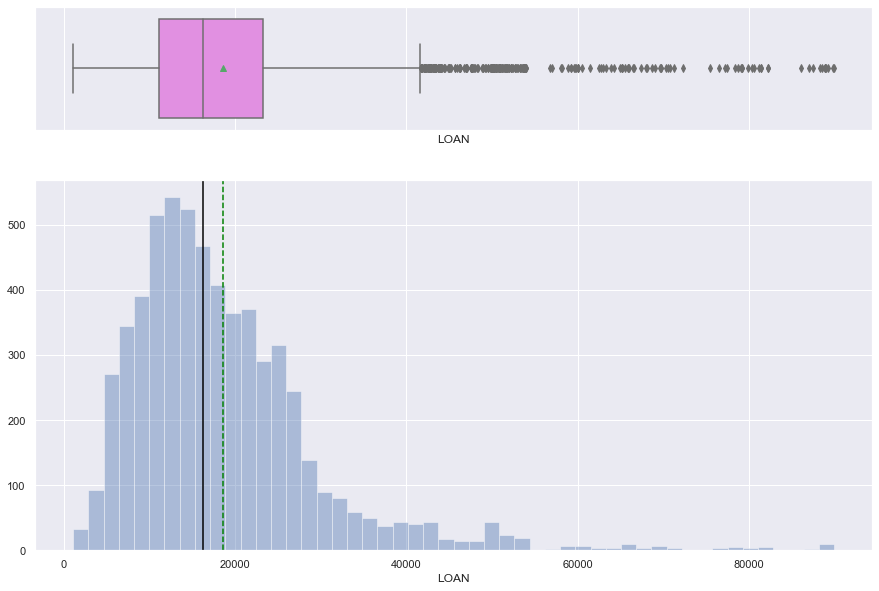

In [23]:
histogram_boxplot(data['LOAN'])

In [24]:
print("Boxplot Stats:")
print()
print("Q1_LOAN: ", hmeq['LOAN'].quantile(0.25))
print("Q2_LOAN: ", hmeq['LOAN'].quantile(0.50))
print("Q3_LOAN: ", hmeq['LOAN'].quantile(0.75))


Boxplot Stats:

Q1_LOAN:  11100.0
Q2_LOAN:  16300.0
Q3_LOAN:  23300.0


**OBS:**
- Loan amount distribution is right-skewed.
- Many outlier loan amounts exist above the "Q3 maximum".
- Zero outlier loan amounts exist less than the "Q1 minimum".

#### "DEBTINC"

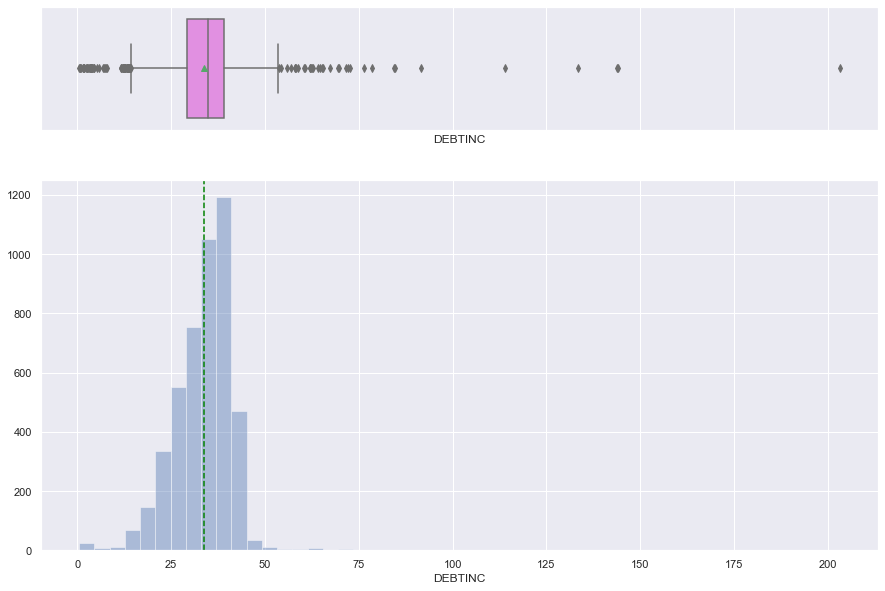

In [25]:
histogram_boxplot(hmeq['DEBTINC'])

In [26]:
print("Boxplot Stats:")
print()
print("Q1_DEBTINC: ", hmeq['DEBTINC'].quantile(0.25))
print("Q2_DEBTINC: ", hmeq['DEBTINC'].quantile(0.50))
print("Q3_DEBTINC: ", hmeq['DEBTINC'].quantile(0.75))

Boxplot Stats:

Q1_DEBTINC:  29.140031372
Q2_DEBTINC:  34.818261819
Q3_DEBTINC:  39.003140628


**OBS:**
- Debt:income ratio distribution is relatively normal.
- Outlier loan amounts exist above the "Q3 maximum" and 
  below the "Q1 minimum".

#### "YOJ"

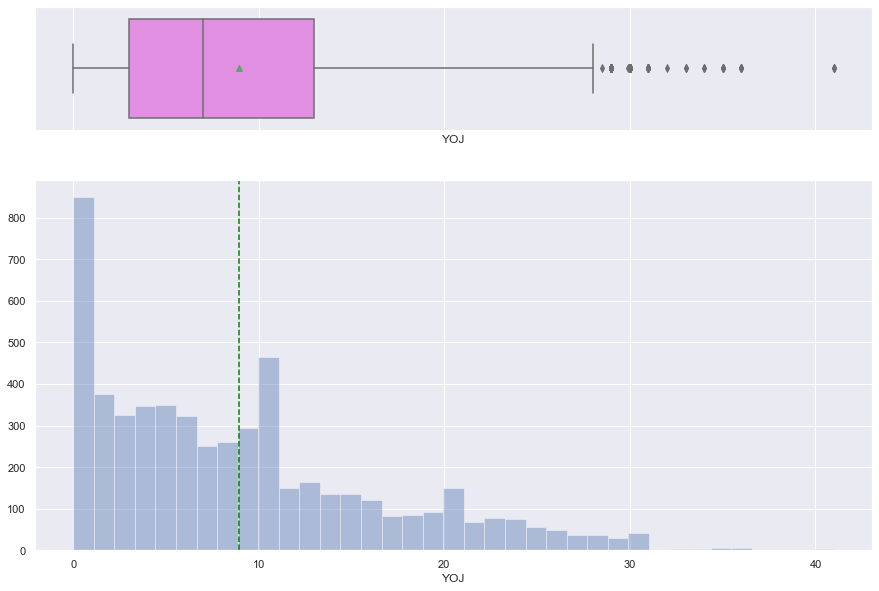

In [27]:
histogram_boxplot(hmeq['YOJ'])

In [28]:
print("Boxplot Stats:")
print()
print("Q1_YOJ: ", hmeq['YOJ'].quantile(0.25))
print("Q2_YOJ: ", hmeq['YOJ'].quantile(0.50))
print("Q3_YOJ: ", hmeq['YOJ'].quantile(0.75))

Boxplot Stats:

Q1_YOJ:  3.0
Q2_YOJ:  7.0
Q3_YOJ:  13.0


**OBS:**
- The greatest proportion of HE loans exist for people who have worked at their job between 0-10 years.
- The median job term for HE loans is 7 years.

### Univariate Analysis - Categorical Data

#### Analyze Barplot for "DELINQ"

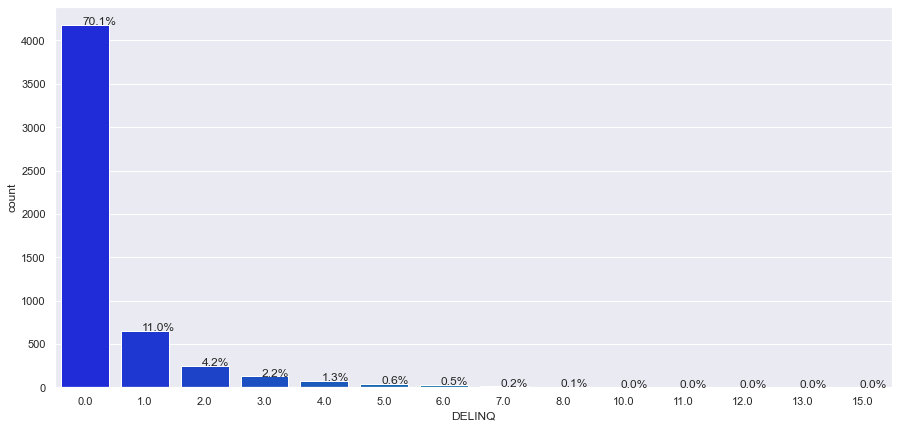

In [30]:
#Build barplot for DELINQ

plt.figure(figsize=(15,7))
ax = sns.countplot(hmeq["DELINQ"],palette='winter')
perc_on_bar(ax,hmeq["DELINQ"])

**OBS:**
- 70% of the cases own 0 delinquent credit lines.
- 11% of the cases own 1 delinquent credit lines.
- 1.4% of the cases own 5-8 delinqunt credit lines.
- 8 delinquent credit lines is the maximum observed in cases.

#### Analyze Barplot for "REASON"

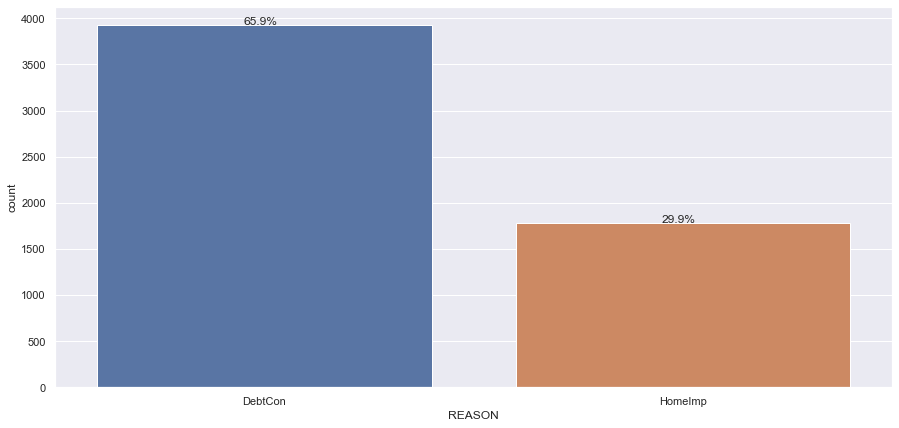

In [31]:
plt.figure(figsize=(15,7))
ax = sns.countplot(hmeq["REASON"])
perc_on_bar(ax,hmeq["REASON"])

**OBS:**
- 66% of HE loan cases are reasoned as "debt consolidation".
- 30% of HE loan cases are reasoned as "home improvement".
- 4% of HE loan cases are due to reasons unknown.

#### Analyze Barplot for "JOB"

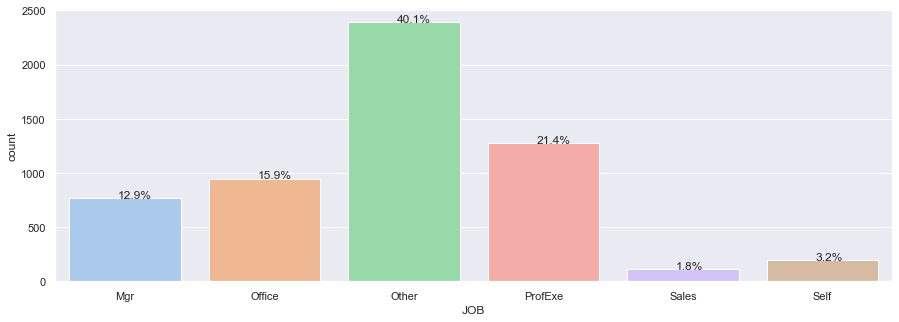

In [27]:
plt.figure(figsize=(15,5))
ax = sns.countplot(hmeq["JOB"],palette='pastel')
perc_on_bar(ax,hmeq["JOB"])

**OBS:**
- In 12.9% of HE loan cases, client works as a manager.
- In 21.4% of HE loan cases, clients are working professionals.
- In 3.2% of HE loan cases, clients are self-employed.

## Bivariate Analysis

#### Analyze BAD vs Loan

<AxesSubplot:xlabel='BAD', ylabel='LOAN'>

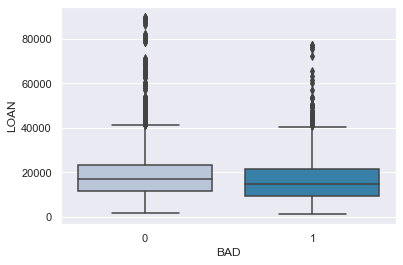

In [28]:
sns.boxplot(hmeq["BAD"],hmeq['LOAN'],palette="PuBu")

**OBS:**
- Q1, Q2, and Q3 are nearly equal between repaid vs defaulted HE loans.
- Minimum and maximum are nearly equal between repaid vs defaulted HE loans.
- Repaying/defaulting a HE loan appears to be uncorrelated with 
  the HE loan amount.

#### Analyze JOB vs Loan

<AxesSubplot:xlabel='JOB', ylabel='LOAN'>

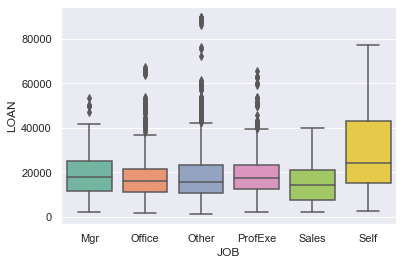

In [29]:
sns.boxplot(hmeq["JOB"],hmeq['LOAN'],palette="Set2")

**OBS:**
- Q1, Q2 are nearly equal across Managers, Office workers, Other, and Professionals.
- Self-employed clients yield a maximum HE loan amount of $80,000.

#### Analyze REASON vs Loan


<AxesSubplot:xlabel='REASON', ylabel='LOAN'>

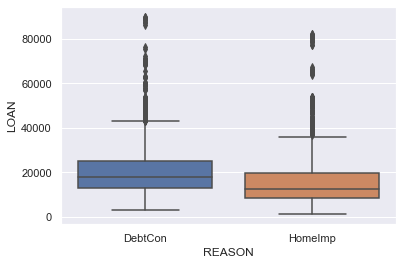

In [30]:
sns.boxplot(hmeq["REASON"],hmeq['LOAN'])

**OBS:**
- "Homeimp" clients request a lower maximum HE loan amount vs "Debtcon" clients.
- "Debtcon" clients request a higher median HE loan amount vs "Homeimp" clients.

#### Analyze JOB vs Value


<AxesSubplot:xlabel='BAD', ylabel='VALUE'>

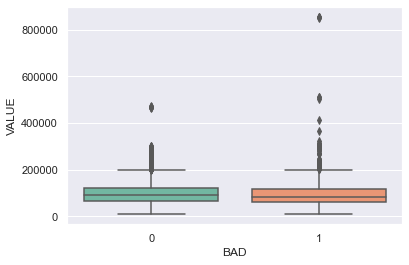

In [31]:
sns.boxplot(hmeq["BAD"],hmeq['VALUE'],palette="Set2")

**OBS:**
- Defaulting or prepaying a loan is uncorrelated with the HE loan amount.
- Clients who default on HE loans request larger $$ amounts.

### **Bivariate Analysis: Two Continuous Variables**

<AxesSubplot:xlabel='VALUE', ylabel='MORTDUE'>

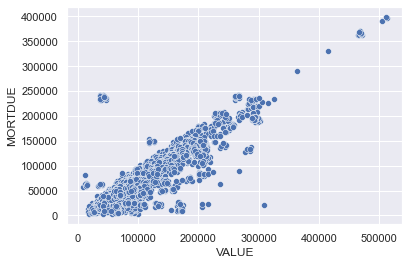

In [32]:
sns.scatterplot(hmeq["VALUE"],hmeq['MORTDUE'],palette="PuBu")

**OBS:**
- As property value increases, mortdue increases (+ correlation).
- Overlapping/tightly clustered scatter plot.

<AxesSubplot:xlabel='DEBTINC', ylabel='LOAN'>

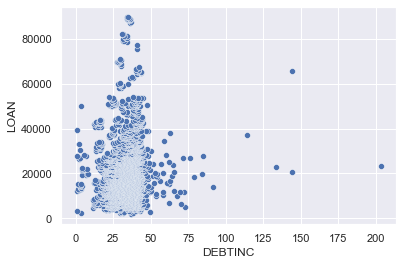

In [33]:
sns.scatterplot(hmeq["DEBTINC"],hmeq['LOAN'],palette="PuBu")

**OBS:**
- No correlation between DEBTINC and Loan.

<AxesSubplot:xlabel='YOJ', ylabel='DELINQ'>

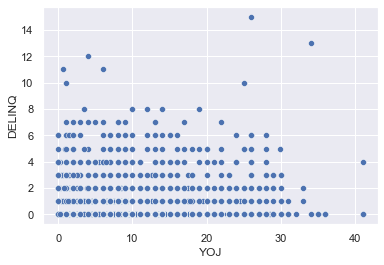

In [34]:
sns.scatterplot(hmeq["YOJ"],hmeq['DELINQ'],palette="deep")

**OBS:**
- No correlation between YOJ and DELINQ.

<AxesSubplot:xlabel='YOJ', ylabel='CLNO'>

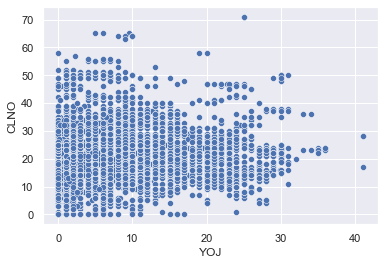

In [35]:
sns.scatterplot(hmeq["YOJ"],hmeq['CLNO'],palette="deep")

**OBS:**
- No correlation between YOJ and CLNO.

### **Bivariate Analysis:  BAD vs Categorical Variables**

In [36]:
### Function to plot stacked bar charts for categorical columns

def stacked_plot(x):
    sns.set(palette='nipy_spectral')
    tab1 = pd.crosstab(x,hmeq['BAD'],margins=True)
    print(tab1)
    print('-'*120)
    tab = pd.crosstab(x,hmeq['BAD'],normalize='index')
    tab.plot(kind='bar',stacked=True,figsize=(10,5))
    plt.legend(loc='lower left', frameon=False)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1))
    plt.show()

#### Plot stacked bar plot for for BAD and REASON

BAD         0     1   All
REASON                   
DebtCon  3183   745  3928
HomeImp  1384   396  1780
All      4567  1141  5708
------------------------------------------------------------------------------------------------------------------------


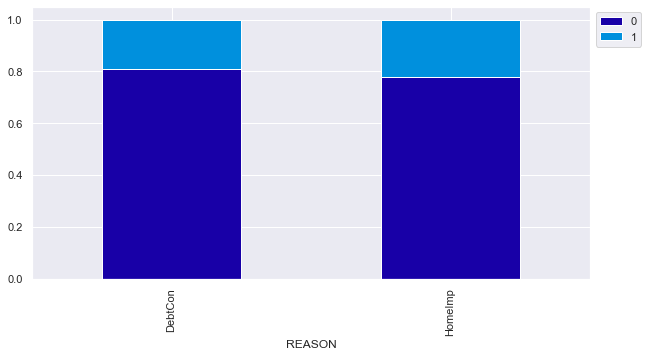

In [37]:
# Plot stacked bar plot for BAD and REASON
stacked_plot(hmeq['REASON'])

**OBS:**
- 81% of clients in "DebtCon" repaid the HE loan amount.
- Ratio of repaid:defaulted loans for the "Debtcon" and "Homeimp" groups is similar.

### Stacked bar plot for BAD and JOB

BAD         0     1   All
JOB                      
Mgr       588   179   767
Office    823   125   948
Other    1834   554  2388
ProfExe  1064   212  1276
Sales      71    38   109
Self      135    58   193
All      4515  1166  5681
------------------------------------------------------------------------------------------------------------------------


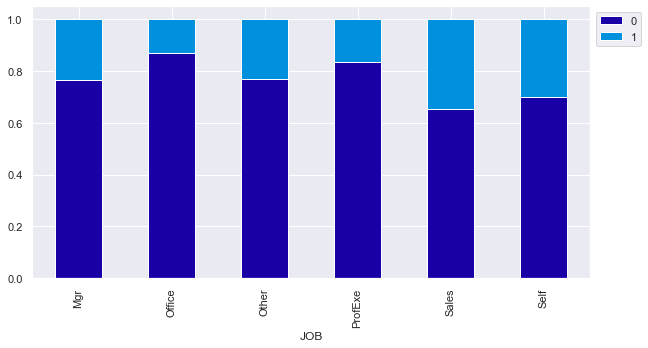

In [38]:
stacked_plot(hmeq['JOB'])

**OBS:**
- Office workers output the minimum proportion of defaulted loans.
- Office workers output the maximum proportion of repaid loans.
- Managers and Professionals output the 3rd and 2nd largest proportion of repaid loans.

### **Multivariate Analysis**

#### Analyze Correlation Heatmap for Numerical Variables

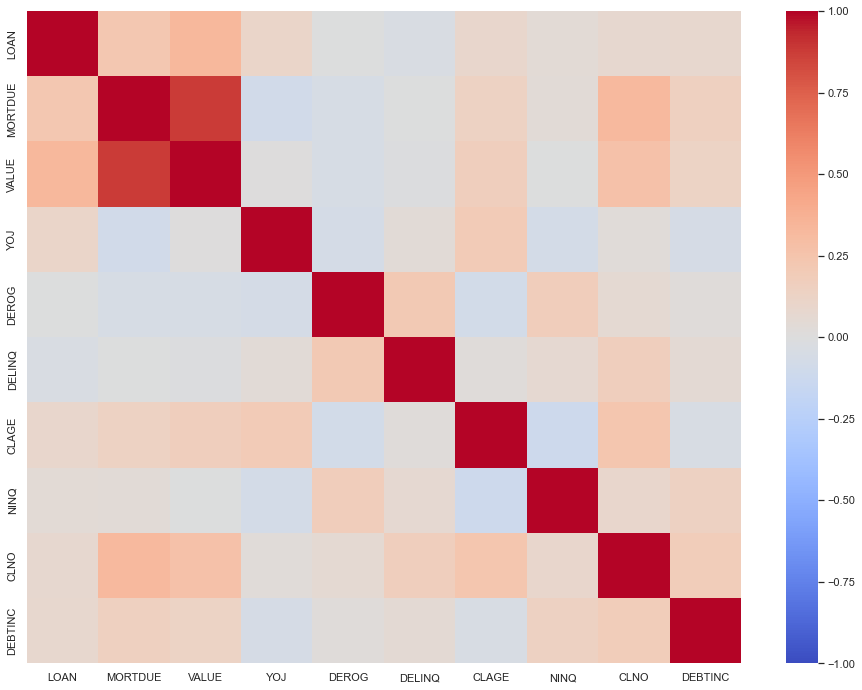

In [39]:
# Separating numerical variables
numerical_col = hmeq.select_dtypes(include=np.number).columns.tolist()

# Build correlation matrix for numerical columns
corr = hmeq[numerical_col].corr()

# plot the heatmap
plt.figure(figsize=(16,12))
sns.heatmap(corr, cmap='coolwarm', vmax=1, vmin=-1,
        fmt=".2f",
        xticklabels=corr.columns,
        yticklabels=corr.columns);

### Build pairplot for the data with hue = 'BAD'


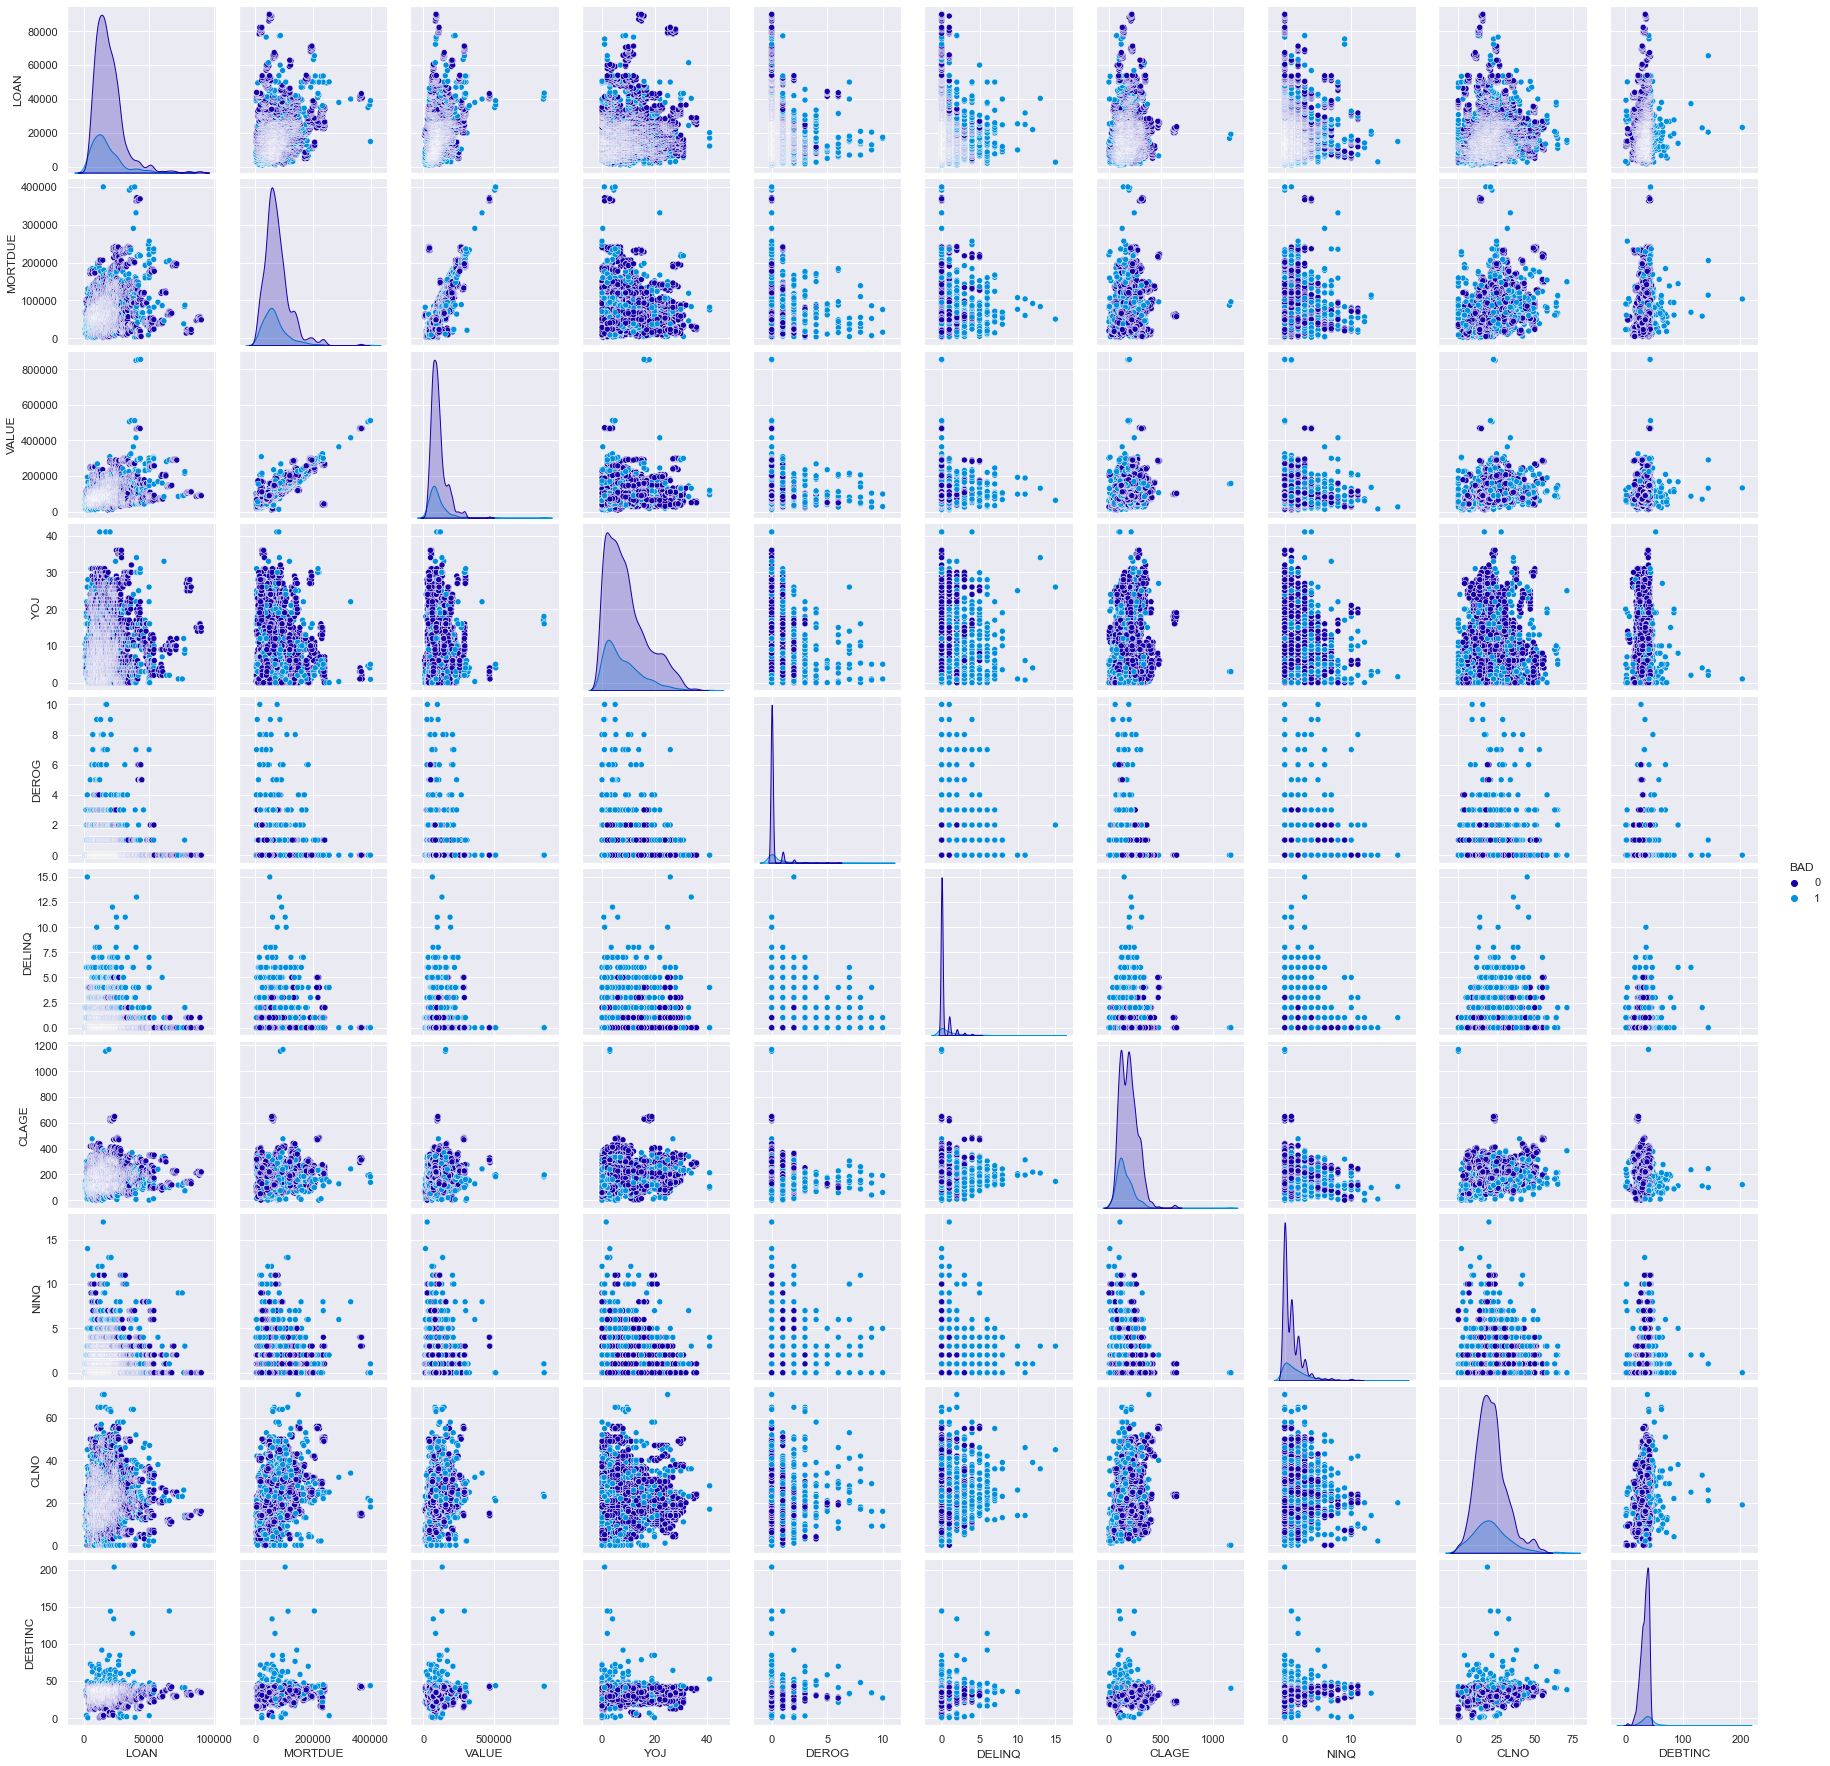

In [40]:
sns.pairplot(hmeq, hue='BAD')

### Treat Outliers

In [41]:
def treat_outliers(df, col):
    '''
    treats outliers in a varaible
    col: str, name of the numerical varaible
    df: data frame
    col: name of the column
    '''

    Q1=df[col].quantile(0.25) # 25th quantile
    Q3=df[col].quantile(0.75) # 75th quantile
    IQR=Q3-Q1   # IQR Range
    Lower_Whisker = Q1 - 1.5*IQR  #define lower whisker
    Upper_Whisker = Q3 + 1.5*IQR  # define upper Whisker
    
    df[col] = np.clip(df[col], Lower_Whisker, Upper_Whisker) # all the values samller than Lower_Whisker will be assigned value of Lower_whisker 
                                                         # and all the values above upper_whishker will be assigned value of upper_Whisker 
    return df



In [42]:
def treat_outliers_all(df, col_list):
    '''
    treat outlier in all numerical varaibles
    col_list: list of numerical varaibles
    df: data frame
    '''
    for c in col_list:
        df = treat_outliers(df,c)
        
    return df

In [43]:
df_raw = hmeq.copy()

# get list of numerical columns
numerical_col = df_raw.select_dtypes(include=np.number).columns.tolist()
df = treat_outliers_all(df_raw,numerical_col)

#### Add new columns in the dataset for each column which has missing values 

In [44]:
# For each column we create a binary flag for the row, 
# if there is missing value in the row, then 1. Else 0. 

def add_binary_flag(df,col):
    '''
    df: It is the dataframe
    col: it is column which has missing values
    It returns a dataframe which has binary falg for missing values in column col
    '''
    new_col = str(col)
    new_col += '_missing_values_flag'
    df[new_col] = df[col].isna()
    return df

In [45]:
# list of columns that has missing values in it
missing_col = [col for col in df.columns if df[col].isnull().any()]

for colmn in missing_col:
    add_binary_flag(df,colmn)

In [46]:
#  Treat Missing values in numerical columns with median and mode in categorical variables
# Select numeric columns.
num_data = hmeq.select_dtypes('number')

# Select string and object columns.
cat_data = hmeq.select_dtypes('category').columns.tolist()#df.select_dtypes('object')

# Fill numeric columns with median.
hmeq[num_data.columns] = num_data.median()

# Fill object columns with model.
for column in cat_data:
    mode = hmeq[column].mode()[0]
    hmeq[column] = hmeq[column].fillna(mode)

In [47]:
num_data.columns

Index(['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ',
       'CLNO', 'DEBTINC'],
      dtype='object')

## **Proposed approach**


**1. Potential techniques:** - What different techniques should be explored?
- PCA to determine splits at each level of a tree
- PCA: what features are important to decide whehter an HE loan should be approved or not?
- Decision Trees 
- Hyperparameter tuning
- Bootstrapping
- Bagging + Random Forests 
- Time-series


**2. Overall solution design** - What is the potential solution design?
- Decision Trees w/ identified PCA features.
- Build multiple Random Forests with DTs to classify if a client will default or repay the HE loan amount.
- Forecasting with AR, MA, ARMA


**3. Measures of success** - What are the key measures of success?
- Low model bias 
- High model reliability and accuracy
- Minimal error and noise


# Stage 2

## **Model Building - Approach**
1. Data preparation
2. Partition the data into train and test set
3. Fit on the train data
4. Tune the model and prune the tree, if required
5. Test the model on test set

## Data Preparation

### **Separating the target variable from other variables**

In [48]:
# create the X(independent variable) matrix
# Drop the dependent variable (BAD) from the dataframe 
X = hmeq.drop(columns='BAD', axis=1)

# Store y(dependent varibale) in separate df
y= hmeq['BAD']

# Create dummy variables for the categorical variables 
X = pd.get_dummies(X, drop_first=True)



### **Splitting the data into 70% train and 30% test set**

In [49]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 1)


## **Model Evaluation Criterion**

#### After understanding the problem statement, think about which evaluation metrics to consider and why. 

In [52]:
#create metric function 
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Not Eligible', 'Eligible'], yticklabels=['Not Eligible', 'Eligible'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

### **Build a Logistic Regression Model** 

In [53]:
# Defining the Logistic regression model
# Fitting the model on the training data 
logreg = LogisticRegression(random_state=0).fit(X_train, y_train)

In [54]:
logreg

LogisticRegression(random_state=0)

#### Checking the performance on the train dataset


              precision    recall  f1-score   support

           0       0.80      1.00      0.89      3355
           1       0.00      0.00      0.00       817

    accuracy                           0.80      4172
   macro avg       0.40      0.50      0.45      4172
weighted avg       0.65      0.80      0.72      4172



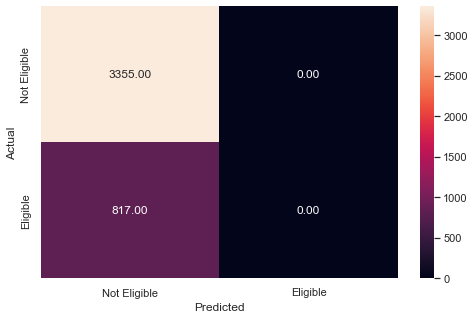

In [55]:
y_train_pred_logreg = logreg.predict(X_train)
y_train_pred_logreg = metrics_score(y_train, y_train_pred_logreg)

#### Checking the performance on the test dataset

              precision    recall  f1-score   support

           0       0.79      1.00      0.88      1416
           1       0.00      0.00      0.00       372

    accuracy                           0.79      1788
   macro avg       0.40      0.50      0.44      1788
weighted avg       0.63      0.79      0.70      1788



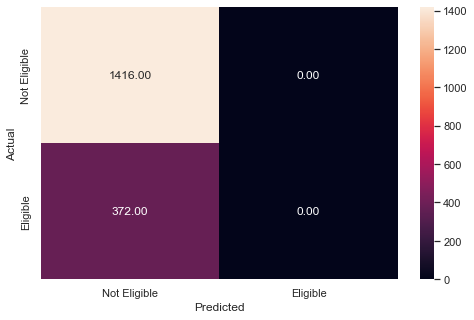

In [56]:
y_test_pred_logreg = logreg.predict(X_test)
y_test_pred_logreg = metrics_score(y_test, y_test_pred_logreg)

**OBS:**
- Train and test sets yield an equal precision of 0.79-0.80 for borrowers who repaid their loans.
- The LR model is scoring 100% on recall for Group 0.
- The LR model is scoring 0% on precision and recall Group 1 on both train and test sets.

### **Decision Tree - Hyperparameter Tuning**

#### GridSearchCV for Hyperparameter tuning on the model

In [57]:
# Implement DT lassifier. 
d_tree_tuned = DecisionTreeClassifier(random_state = 7, class_weight = {0: 0.3, 1: 0.7})


# Grid of parameters to choose from
parameters = {'max_depth': np.arange(2, 10), 
              'criterion': ['gini', 'entropy'],
              'min_samples_leaf': [5, 10, 20, 25]
             }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(recall_score, pos_label = 1)


# Run the grid search
grid_obj = GridSearchCV(d_tree_tuned, parameters, scoring = scorer, cv = 5)


# Fit the GridSearch on train dataset
grid_obj = grid_obj.fit(X_train, y_train)


# Set the clf to the best combination of parameters
d_tree_tuned = grid_obj.best_estimator_


# Fit the best algorithm to the data. 
d_tree_tuned.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.3, 1: 0.7}, max_depth=6,
                       min_samples_leaf=10, random_state=7)

#### Checking the performance on the train dataset

              precision    recall  f1-score   support

           0       0.81      0.96      0.88      3355
           1       0.37      0.11      0.17       817

    accuracy                           0.79      4172
   macro avg       0.59      0.53      0.52      4172
weighted avg       0.73      0.79      0.74      4172



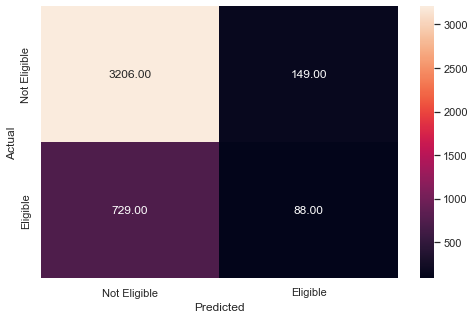

In [58]:
y_pred_train_dt = d_tree_tuned.predict(X_train)
metrics_score(y_train, y_pred_train_dt)

#### Checking the performance on the test dataset

              precision    recall  f1-score   support

           0       0.80      0.94      0.87      1416
           1       0.35      0.12      0.17       372

    accuracy                           0.77      1788
   macro avg       0.57      0.53      0.52      1788
weighted avg       0.71      0.77      0.72      1788



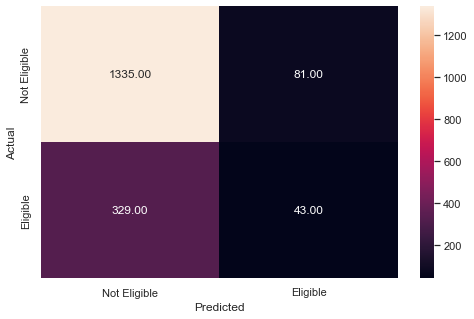

In [59]:
y_pred_test_dt = d_tree_tuned.predict(X_test)
metrics_score(y_test, y_pred_test_dt)

**OBS:**

- Tuned DT model is scoring 0.37 in precision for Group 1 train set.
- Tuned DT model is scoring 0.12 in recall for Group 1 test set.
- Tuned DT model yields a greater score in precision both in train and test sets than our LR model.
- Precision scores in Tuned DT model vs LR model are equal.


#### Plotting the Decision Tree

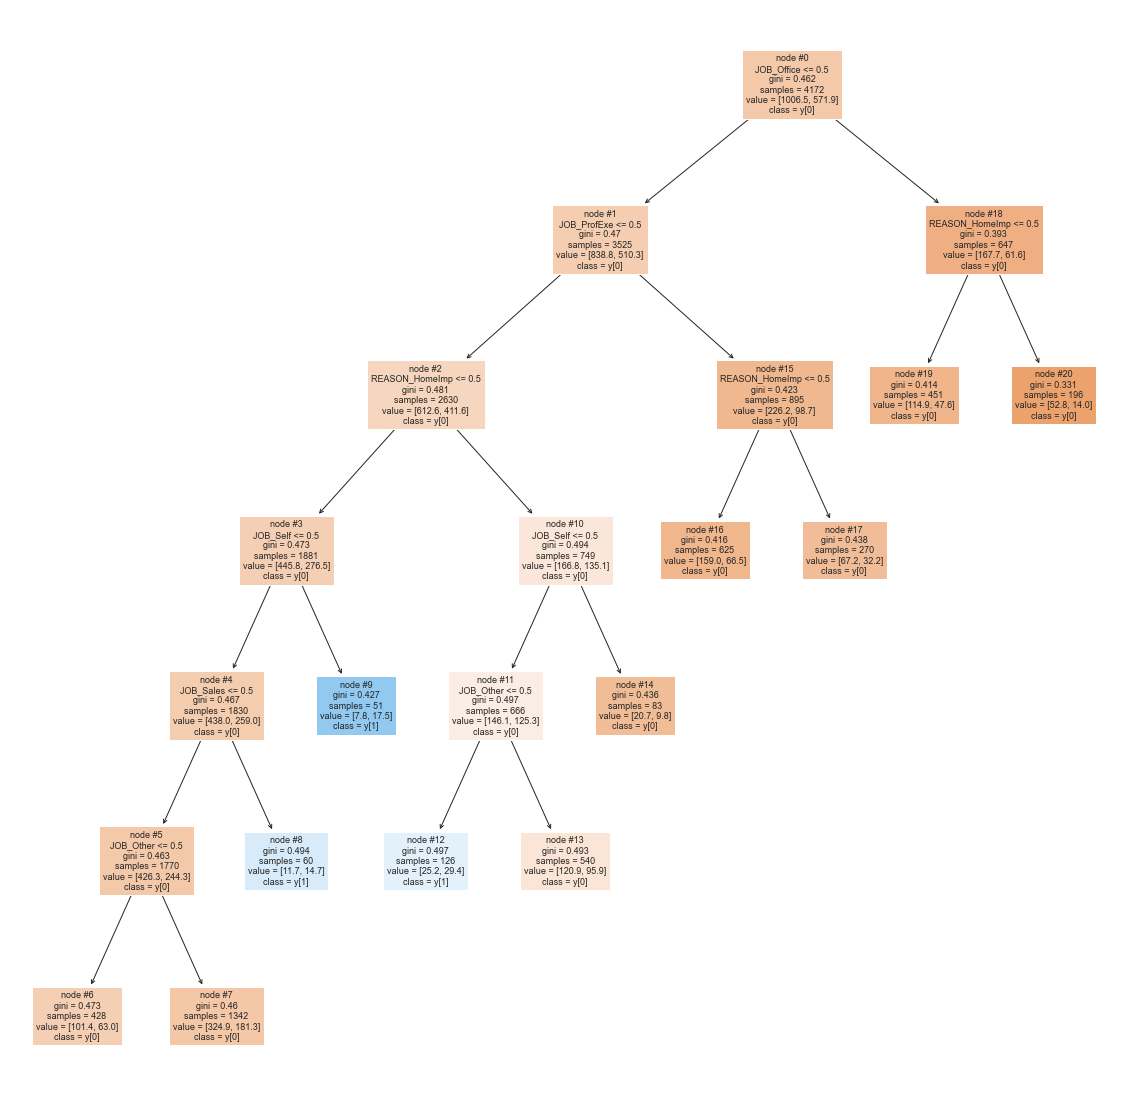

In [60]:
features = list(X.columns)
plt.figure(figsize = (20, 20))
tree.plot_tree(d_tree_tuned, feature_names = features, filled = True, fontsize = 9, node_ids = True, class_names = True, )
plt.show()

**BAD value glossary:** 

    1= Client defaulted on loan 
    0= loan repaid

#### OBS:

- Tuned DT model predicts that the probability an Office worker will repay the HE loan is 1.0.
- Self-employed borrowers are likely to default on their HE loan.
- Overall, Tuned DT model predicts that it is likely for a loaner with the target features will repay the HE loan.
- People who work in sales may or may not repay the HE loan.

### Basic RF Classifier

In [61]:
# Defining and fitting Random forest Classifier

rf_estimator = RandomForestClassifier(random_state = 7)
rf_estimator.fit(X_train, y_train)

RandomForestClassifier(random_state=7)

#### Check performance on the train dataset

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      3355
           1       0.00      0.00      0.00       817

    accuracy                           0.80      4172
   macro avg       0.40      0.50      0.45      4172
weighted avg       0.65      0.80      0.72      4172



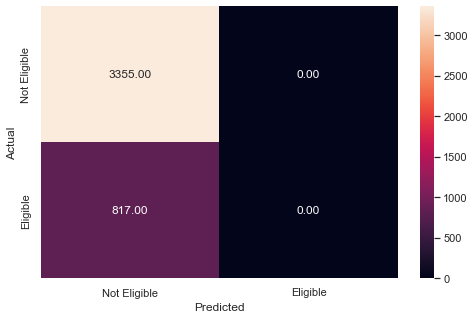

In [62]:
y_pred_train_rf = rf_estimator.predict(X_train)
metrics_score(y_train, y_pred_train_rf)

#### Check performance on the test dataset

              precision    recall  f1-score   support

           0       0.79      1.00      0.88      1416
           1       0.00      0.00      0.00       372

    accuracy                           0.79      1788
   macro avg       0.40      0.50      0.44      1788
weighted avg       0.63      0.79      0.70      1788



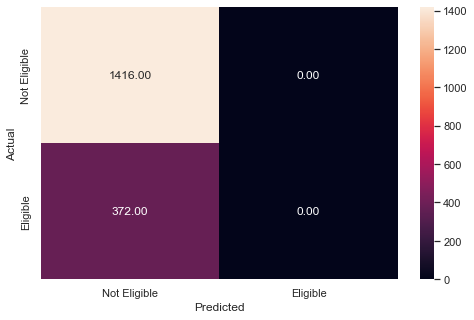

In [63]:
y_pred_test_rf = rf_estimator.predict(X_test)
metrics_score(y_test, y_pred_test_rf)

**OBS:**
- Basic RF classifier yields an accuracy score of 0.46.
- Basic RF classifier yields a weighted precision avg of 0.54
- Basic FR classifier yields a weighted recall avg of 0.48

### **Weighted Random Forest Classifier**


In [64]:
# Fitting the random forest tree classifier on the training data

weighted_rf_estimator = RandomForestClassifier(class_weight = {0: 0.17, 1: 0.83}, random_state = 7)
weighted_rf_estimator.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.17, 1: 0.83}, random_state=7)

              precision    recall  f1-score   support

           0       0.85      0.41      0.56      3355
           1       0.23      0.70      0.34       817

    accuracy                           0.47      4172
   macro avg       0.54      0.56      0.45      4172
weighted avg       0.73      0.47      0.51      4172



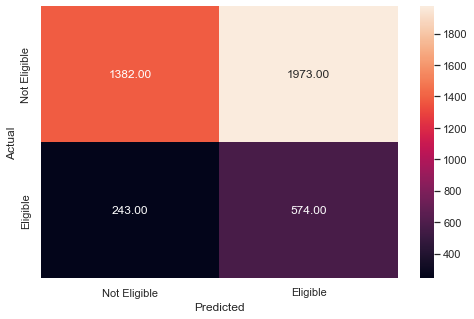

In [65]:
#Check performance on the training data

y_pred_train_weightedrf = weighted_rf_estimator.predict(X_train)
metrics_score(y_train, y_pred_train_weightedrf)

              precision    recall  f1-score   support

           0       0.84      0.42      0.56      1416
           1       0.24      0.69      0.36       372

    accuracy                           0.48      1788
   macro avg       0.54      0.56      0.46      1788
weighted avg       0.71      0.48      0.52      1788



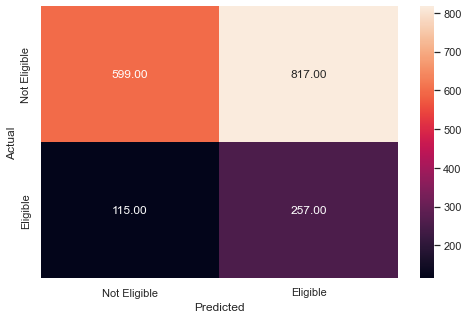

In [66]:
#Check performance on the test data

y_pred_test_weightedrf = weighted_rf_estimator.predict(X_test)
metrics_score(y_test, y_pred_test_weightedrf)

**OBS:**
- RF model yields a precision of 0.23 for Group 1
- RF model yields a recall of 0.41 for Group 0
- RF model yields an f1-score
- RF model yields an accuracy of 0.48

### Tuned Random Forest Classifier

In [67]:
# Defining Random Forest model with class weights class_weight={0: 0.2, 1: 0.8}
rf_estimator_tuned = RandomForestClassifier(class_weight = {0: 0.2, 1: 0.8}, random_state = 1)

# Grid of parameters to choose from
params_rf = {  
        "n_estimators": [100, 250, 500],
        "min_samples_leaf": np.arange(1, 4, 1),
        "max_features": [0.7, 0.9, 'auto'],
}


# Type of scoring used to compare parameter combinations - recall score for class 1
scorer = metrics.make_scorer(recall_score, pos_label = 1)

# Run the grid search
grid_obj = GridSearchCV(rf_estimator_tuned, params_rf, scoring = scorer, cv = 5)



# Fitting Random Forest model
grid_obj = grid_obj.fit(X_train, y_train)

# Set the classifier to the best combination of parameters
rf_estimator_tuned = grid_obj.best_estimator_

#### Check performance on the train dataset

              precision    recall  f1-score   support

           0       0.83      0.73      0.78      3355
           1       0.26      0.39      0.31       817

    accuracy                           0.67      4172
   macro avg       0.55      0.56      0.55      4172
weighted avg       0.72      0.67      0.69      4172



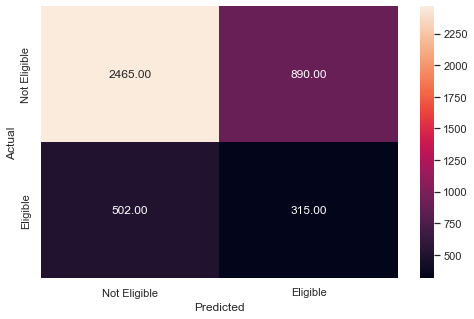

In [68]:
y_pred_train_tunedrf = rf_estimator_tuned.predict(X_train)
metrics_score(y_train, y_pred_train_tunedrf)

#### Check performance on the test dataset

              precision    recall  f1-score   support

           0       0.82      0.74      0.78      1416
           1       0.28      0.40      0.33       372

    accuracy                           0.67      1788
   macro avg       0.55      0.57      0.55      1788
weighted avg       0.71      0.67      0.68      1788



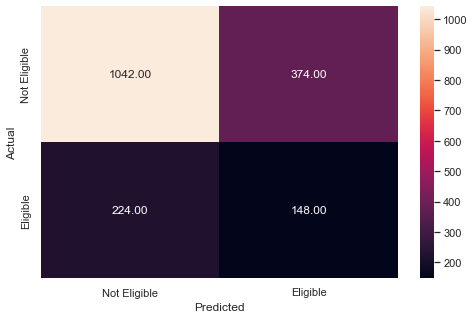

In [69]:
y_pred_test_tunedrf = rf_estimator_tuned.predict(X_test)
metrics_score(y_test, y_pred_test_tunedrf)

**OBS:**
- Tuned RF model yields an accuracy score of 0.67.
- Tuned Rf model yields the #2 ranked accuracy score among all classifier simulations.
- TUned RF model yields a weighted precision avg of 0.71.

#### Plot Feature importance of tuned Random Forest CLF

<AxesSubplot:xlabel='Importance'>

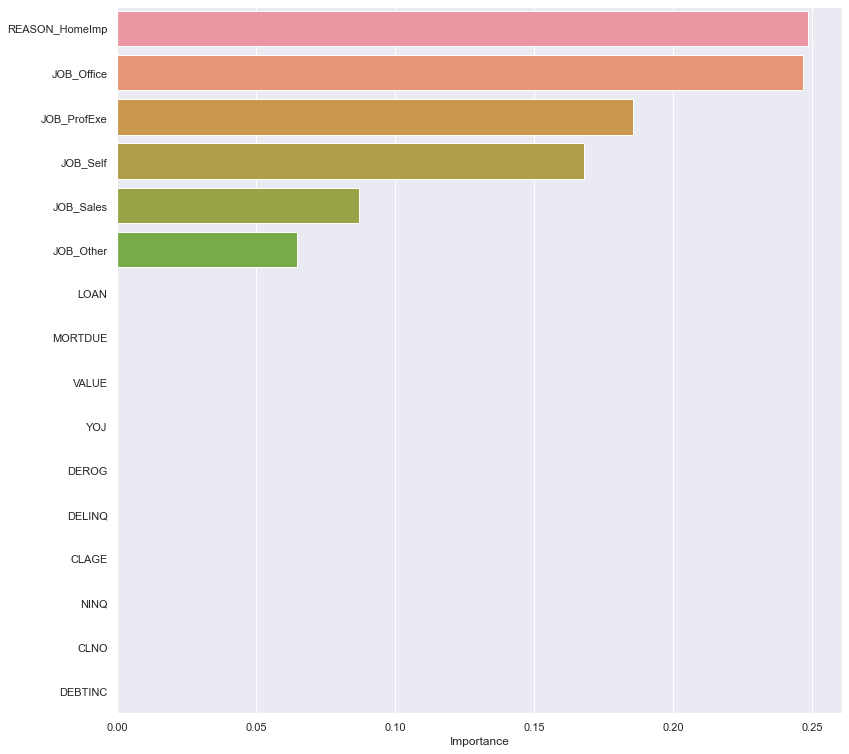

In [70]:
importances = rf_estimator_tuned.feature_importances_
columns = X.columns
importance_df = pd.DataFrame(importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)
plt.figure(figsize = (13, 13))
sns.barplot(importance_df.Importance, importance_df.index)

### **Compare Model Performances:**

In [71]:
def get_recall_score(model,flag=True,X_train=X_train,X_test=X_test):
    '''
    model : classifier to predict values of X

    '''
    a = [] # defining an empty list to store train and test results
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    train_recall = metrics.recall_score(y_train,pred_train)
    test_recall = metrics.recall_score(y_test,pred_test)
    a.append(train_recall) # adding train recall to list 
    a.append(test_recall) # adding test recall to list
    
    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True: 
        print("Recall on training set : ",metrics.recall_score(y_train,pred_train))
        print("Recall on test set : ",metrics.recall_score(y_test,pred_test))
    
    return a # returning the list with train and test scores

In [72]:
##  Function to calculate precision score
def get_precision_score(model,flag=True,X_train=X_train,X_test=X_test):
    '''
    model : classifier to predict values of X

    '''
    b = []  # defining an empty list to store train and test results
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    train_precision = metrics.precision_score(y_train,pred_train)
    test_precision = metrics.precision_score(y_test,pred_test)
    b.append(train_precision) # adding train precision to list
    b.append(test_precision) # adding test precision to list
    
    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True: 
        print("Precision on training set : ",metrics.precision_score(y_train,pred_train))
        print("Precision on test set : ",metrics.precision_score(y_test,pred_test))

    return b # returning the list with train and test scores

In [73]:
##  Function to calculate accuracy score
def get_accuracy_score(model,flag=True,X_train=X_train,X_test=X_test):
    '''
    model : classifier to predict values of X

    '''
    c = [] # defining an empty list to store train and test results
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    c.append(train_acc) # adding train accuracy to list
    c.append(test_acc) # adding test accuracy to list
    
    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True:
        print("Accuracy on training set : ",model.score(X_train,y_train))
        print("Accuracy on test set : ",model.score(X_test,y_test))
    
    return c # returning the list with train and test scores

### Generate list of all models

- y_test_pred_logreg,
- y_pred_test_dt,
- y_pred_test_rf,
- y_pred_test_weightedrf,
- y_pred_test_tunedrf

In [74]:
# Make the list of all the model names 
models = [y_test_pred_logreg,
          y_pred_test_dt,
          y_pred_test_weightedrf,
          y_pred_test_tunedrf]

# defining empty lists to add train and test results
acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []

# looping through all the models to get the accuracy,recall and precision scores
for model in models:
     # accuracy score
    j = get_accuracy_score(model,False)
    acc_train.append(j[0])
    acc_test.append(j[1])

    # recall score
    k = get_recall_score(model,False)
    recall_train.append(k[0])
    recall_test.append(k[1])

    # precision score
    l = get_precision_score(model,False)
    precision_train.append(l[0])
    precision_test.append(l[1])

AttributeError: 'NoneType' object has no attribute 'score'

## Conclusion:

- Our built ML models still require some tuning and recalibration. Of the bunch we have tested so far, I propose we adopt our tuned RF solution.
- Tuned RF is the most accurate classifier we implemented: 
  - (0.82 precision for status 1, 0.28 precision for status 0, accuracy score: 0.67)
- We should use this model as a predictor of whether or not a client will repay or default on their HE loan.

PCA suggests that the 4 key features of HE loan clients ranked DESC by 'importance' are:
- Reason- HomeImp 
- Job- Office
- Job- ProfExe 
- Job- Sales


## Business Recommendations:

- Office workers output the maximum proportion of repaid HE loans, supporting our Feature Importance analysis.
- Our DT plot indicates clients who possess 1+ observed features are likely to repay their HE loan.
- Build and tweak new classifier models whose client attributes align with our PCA top 4.
- Seaborn heatmap indicates that there is little to no correlation between duo combinations of observed features.
- We will need to run tests to confirm/deny the presence of a confounding variable among our features.
- Will be efficient to conduct additional studies to identify possible features of clients who default on HE loans.
- How will our results compare to clients who request different types of loans? (e.g. student, auto, personal)